# NER for Extracting Stock Mentions on Reddit

## NER Extraction

This project is copied and editted from the following project:

https://towardsdatascience.com/ner-for-extracting-stock-mentions-on-reddit-aa604e577be

In [1]:
import spacy
from spacy import displacy
from collections import Counter
import pandas as pd
import numpy as np
from tqdm import tqdm
from pprint import pprint
import nltk
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

tqdm.pandas()

# Select a spacy model
We select the medium model to speed the process up

In [2]:
#nlp = spacy.load('en_core_web_sm')
nlp = spacy.load('en_core_web_md')
#nlp = spacy.load('en_core_web_lg')

C:\Users\WeiYanPEH\anaconda3\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_core_web_lg' (3.4.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


# List of Subreddits

In [3]:
SUB_list = [
            'investing',
            'wallstreetbets',
            'stocks',
            'pennystocks',
            'robinhood',
            'GME',
            'amcstock',
            'Cryptocurrency',
            'smallstreetbets',
            'traders',
            'Wallstreetbetsnew',
            'options',
            'StockMarket',
            'ethtrader',
           ]

# Select NER for analysis
There are a lot of NER that can be extracted with the spacy NER model.

However, not all are relevent in this project.

We only select those that are related to trade/investment
- GPE
- LOC
- NORP
- ORG
- PERSON
- PRODUCT

In [4]:
label_list = [
              #'CARDINAL', 
              #'DATE', 
              #'EVENT', 
              #'FAC', 
              'GPE', 
              #'LANGUAGE', 
              #'LAW', 
              'LOC', 
              #'MONEY', 
              'NORP', 
              #'ORDINAL', 
              'ORG', 
              #'PERCENT', 
              'PERSON', 
              'PRODUCT', 
              #'QUANTITY', 
              #'TIME', 
              #'WORK_OF_ART',
             ]

# Create function to extract specific NER from sentences

In [5]:
def get_orgs(text):
    # process the text with our SpaCy model to get named entities
    
    doc = nlp(text)
    # initialize list to store identified organizations
    
    all_list = []
    # loop through the identified entities and append ORG entities to org_list
    for label in label_list:
        org_list = []
        for entity in doc.ents:
            if entity.label_ == label:
                org_list.append(entity.text)
    # if organization is identified more than once it will appear multiple times in list
    # we use set() to remove duplicates then convert back to list
        org_list = list(set(org_list))
        all_list.append(org_list)
        
    return all_list

# Concatenate all the data together

In [6]:
df_all = pd.DataFrame()

for SUB in SUB_list:
    df = pd.read_csv('./data/reddit_' + SUB + '_NEW.csv', sep='|')  
    print(SUB, df.shape)
    df_all = pd.concat([df, df_all], axis=0)
    
df = df_all
print('Total:', df.shape)

investing (927, 9)
wallstreetbets (930, 9)
stocks (937, 9)
pennystocks (890, 9)
robinhood (384, 9)
GME (990, 9)
amcstock (979, 9)
Cryptocurrency (928, 9)
smallstreetbets (913, 9)
traders (783, 9)
Wallstreetbetsnew (890, 9)
options (826, 9)
StockMarket (858, 9)
ethtrader (897, 9)
Total: (12132, 9)


# Remove empty threads

In [7]:
df = df.dropna(subset=['selftext']).reset_index(drop=True)
print(df.shape)

(6197, 9)


# Extract NER

In [8]:
df_temp = df.copy()
x =  df_temp['selftext'].progress_apply(get_orgs)
df_temp = pd.DataFrame(list(x), columns = label_list)
df_comb = pd.concat([df, df_temp], axis=1)
print(df_comb.shape)

100%|██████████| 6197/6197 [03:48<00:00, 27.17it/s] 

(6197, 15)


# For each entity, compute the frequency and counts of each unique occurance

However, we noticed that there are a lot of wrong entities extracted

In [9]:
labels_all = {}
labels_frequency = {}

for i, label in enumerate(label_list):
    x = df_temp[label].to_list()
    x = [x for sublist in x for x in sublist]

    labels_all[label] = x

    freq = Counter(x)
    labels_frequency[label] = freq

    print('\n' + label, len(x))
    pprint(freq.most_common(10))


GPE 3254
[('US', 328),
 ('U.S.', 173),
 ('China', 126),
 ('Canada', 95),
 ('S&amp;P', 90),
 ('the United States', 78),
 ('UK', 67),
 ('Russia', 63),
 ('USA', 62),
 ('Ukraine', 57)]

LOC 468
[('Europe', 135),
 ('North America', 33),
 ('Asia', 26),
 ('Latin America', 10),
 ('europe', 8),
 ('Athabasca Basin', 7),
 ('Africa', 6),
 ('Midwest', 6),
 ('South America', 6),
 ('Americas', 5)]

NORP 993
[('^of', 148),
 ('European', 84),
 ('American', 74),
 ('Chinese', 52),
 ('Canadian', 48),
 ('Russian', 26),
 ('💎', 25),
 ('Americans', 24),
 ('German', 22),
 ('GMEOrphans', 21)]

ORG 18118
[('SEC', 241),
 ('Robinhood', 214),
 ('GME', 202),
 ('Fed', 179),
 ('^of', 148),
 ('# Join Robinhood', 148),
 ('AMC', 117),
 ('Reddit', 106),
 ('Amazon', 99),
 ('Company', 99)]

PERSON 5112
[('^The ^content ^in', 148),
 ('^In', 148),
 ('^to ^vary', 148),
 ('^market ^downturn', 148),
 ('^are', 148),
 ('^assumptions', 148),
 ('Powell', 54),
 ('Roth', 52),
 ('max', 51),
 ('Elon Musk', 51)]

PRODUCT 626
[('Twitter'

# Remove several phase/words that causes the errors

In [10]:
# Remove exact words
BLACKLIST = [
             'ev', 'covid', 'etf', 'nyse', 'sec', 'spac', 'fda', 'max', '💎',
             'mnss65', 'Brigading', 'Megathreads', 'GMEOrphans', 'YESTERDAY',
             'sch_200p', '=c&amp;ta=st_c',
            ]

# Remove words containing substring
BLACKLIST2 = [
              #'reddit', 
              '\n', 'www', '\xa0', '|', 'http', 
              '\\', '^', '=', '%', '+', ';', '[', ']',
             ]

def get_orgs(text):
    
    doc = nlp(text)

    all_list = []
    for label in label_list:
        org_list = []
        for entity in doc.ents:
            if ((entity.label_ == label) and 
                (entity.text.lower() not in BLACKLIST) and
                (not any(substring in entity.text.lower() for substring in BLACKLIST2))
                ):
                org_list.append(entity.text)

        org_list = list(set(org_list))
        all_list.append(org_list)
        
    return all_list

# Re-extract NER

In [11]:
df_temp = df.copy()
x =  df_temp['selftext'].progress_apply(get_orgs)
df_temp = pd.DataFrame(list(x), columns = label_list)
df_comb = pd.concat([df, df_temp], axis=1)
print(df_comb.shape)

100%|██████████| 6197/6197 [03:57<00:00, 26.07it/s] 

(6197, 15)


In [12]:
labels_all = {}
labels_frequency = {}

for i, label in enumerate(label_list):
    x = df_temp[label].to_list()
    x = [x for sublist in x for x in sublist]

    labels_all[label] = x

    freq = Counter(x)
    labels_frequency[label] = freq

    print('\n' + label, len(x))
    pprint(freq.most_common(5))


GPE 3057
[('US', 328),
 ('U.S.', 173),
 ('China', 126),
 ('Canada', 95),
 ('the United States', 78)]

LOC 467
[('Europe', 135),
 ('North America', 33),
 ('Asia', 26),
 ('Latin America', 10),
 ('europe', 8)]

NORP 801
[('European', 84),
 ('American', 74),
 ('Chinese', 52),
 ('Canadian', 48),
 ('Russian', 26)]

ORG 15789
[('Robinhood', 214),
 ('GME', 202),
 ('Fed', 179),
 ('# Join Robinhood', 148),
 ('AMC', 117)]

PERSON 3817
[('Powell', 54),
 ('Roth', 52),
 ('Elon Musk', 51),
 ('Jerome Powell', 48),
 ('Ryan Cohen', 43)]

PRODUCT 592
[('Twitter', 48), ('Coinbase', 22), ('Euro', 11), ('Merge', 9), ('DocuSign', 7)]


# Create Word Cloud to illustrate what entities are the most common

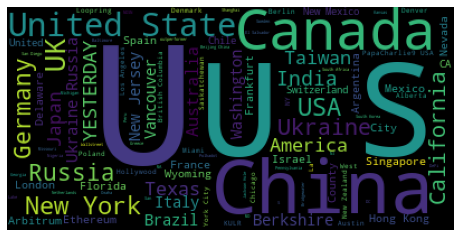

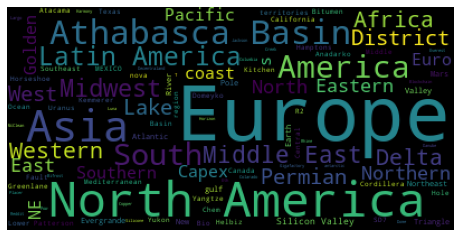

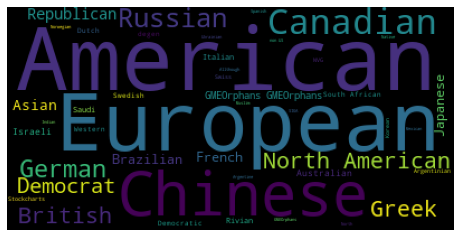

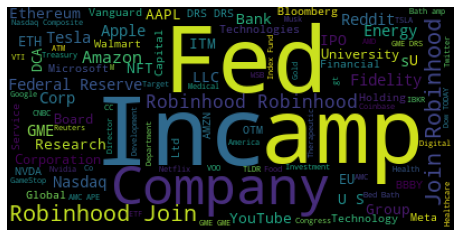

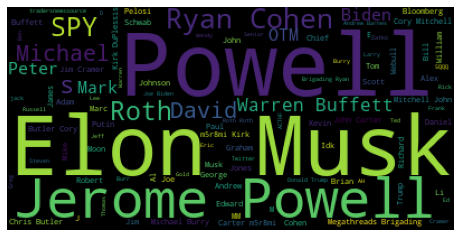

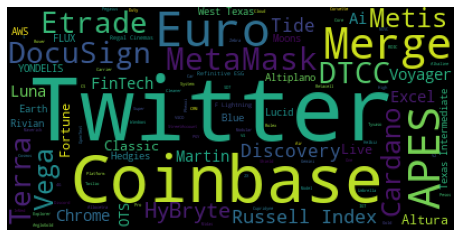

In [13]:
for i, label in enumerate(label_list):

    string = labels_all[label]
    string = ' '.join(string)

    wc = WordCloud(stopwords=STOPWORDS,
                   background_color='black',
                   max_words=100).generate(string)

    plt.figure(figsize=(8,8))
    plt.clf()
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

# Save NER extracted data

In [14]:
df_comb.to_csv('./data/processed/reddit_all_ner.csv', sep='|', index=False)